In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import interpolate
from tkinter import filedialog
import sys
sys.path.append("/Users/michelle-julieotto/Documents/Wichtig/Arbeit/PTB/Ofenprofil/Libraries")
from Photonic_Data_Analysis_V1 import *
from Photonic_fit_funtction_lib_V2021_10 import *
from Photonic_instruments_lib_V2023_07 import *
# %matplotlib ipympl

load_default_plot_font(fontsize = 20)


In [3]:
files = filedialog.askopenfilename(multiple=True)


In [4]:
# Read txt files as dataframe
def read_fiber(file):
    # Wavelength (nm)   Power (mW)	Detector 1	Detector 2	
    data_df = pd.read_csv(file, sep= '\t', header=0, usecols=["Wavelength (nm)", "Detector 1"])
    return data_df
def read_elect(file):
    # Wavelength (nm)   Power (mW)	Detector 1	Detector 2	
    data_df = pd.read_table(file, comment="#", encoding="iso-8859-1", header=0, sep= ';', usecols=["Cali. Temperature  / °C"])
    # print(data_df)
    return data_df


In [5]:
dfs_fiber_000 = []
dfs_fiber_100 = []
dfs_fiber_200 = []
dfs_fiber_300 = []
dfs_fiber_400 = []
dfs_fiber_500 = []
dfs_fiber_600 = []
dfs_fiber_700 = []

dfs_elect = []
set_temperature = [0, 100, 200, 300, 400, 500, 600, 700]

# Use read_txt function to read all files
for file in files:
    if 'txt' in file:
        if "electrical" in file: # Reference thermometer (starting at 100C)
            data_df = read_elect(file)
            dfs_elect.append(data_df)
        elif "MS" in file: # Fiber thermometer (starting at 0C)
            data_df = read_fiber(file)
            if '000' in file:
                dfs_fiber_000.append(data_df)
            elif '100' in file:
                dfs_fiber_100.append(data_df)
            elif '200' in file:
                dfs_fiber_200.append(data_df)
            elif '300' in file:
                dfs_fiber_300.append(data_df)
            elif '400' in file:
                dfs_fiber_400.append(data_df)
            elif '500' in file:
                dfs_fiber_500.append(data_df)
            elif '600' in file:
                dfs_fiber_600.append(data_df)
            elif '700' in file:
                dfs_fiber_700.append(data_df)


            

In [6]:
dfs_fiber = [dfs_fiber_000, dfs_fiber_100, dfs_fiber_200, dfs_fiber_300, dfs_fiber_400, dfs_fiber_500, dfs_fiber_600, dfs_fiber_700]


In [7]:
plt.figure(figsize=(10,7))
x = np.array(dfs_fiber[1][0].loc[:, "Wavelength (nm)"])
y = np.array(dfs_fiber[1][0].loc[:, "Detector 1"])
calculate_peaks(x, y, expected_peaks = 3, fit_type = voigtlin_same_cen_const, plot = True)

IndexError: list index out of range

<Figure size 1000x700 with 0 Axes>

In [ ]:
# Calculating peaks of all FBGs
def calc_peaks(data, plot = False):
    # def voigtlin_same_cen_const(x, ampG1, sigmaG1, cenL1, ampL1, widL1):
    #     return (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenL1)**2)/((2*sigmaG1)**2)))) +\
    #     ((ampL1*widL1**2/((x-cenL1)**2+widL1**2)) )

    x = np.array(data.loc[:, "Wavelength (nm)"])
    y = np.array(data.loc[:, "Detector 1"])
    if plot == True:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6), gridspec_kw={'width_ratios': [1.5, 2]})
        axs[0].plot(x, y)
        axs[1].plot(x, y)

    dx = abs(x[0]-x[101])/100
    dy = abs(y[0]-np.max(y))/1000
    peaks, properties = find_peaks(y, height = 0.5, distance = 1/dx, width=1/dy)
    width = properties["widths"]
    amp = properties["peak_heights"]
    cen = x[peaks]
    fit_type = voigtlin_same_cen_const
    peaks_fit = []
    left_base = properties['left_ips']
    right_base = properties['right_ips']
    for i in range(0, len(peaks)):
        try: 
            x_fit = x[int(left_base[i]-width[i]*2):int(right_base[i]+width[i]*2)]
            y_fit = y[int(left_base[i]-width[i]*2):int(right_base[i]+width[i]*2)]
            p0 = [amp[i], 1, cen[i], amp[i], width[i]]
            popt, pcov = curve_fit(fit_type, x_fit, y_fit, p0=p0)
            peak_fit, properties = find_peaks(fit_type(x, *popt), height = 0.75, distance = 1/dx, width=1/dy)
            if plot == True:
                axs[1].plot(x_fit, fit_type(x_fit, *popt))
            if abs(x[peaks[i]]-x[peak_fit[0]]) < 0.5:
                peaks_fit.append(peak_fit[0])
            else:
                peaks_fit.append(peaks[i])
                print('No Fit')
        except:
            peaks_fit.append(peaks[i])
            print('No Fit')

    if plot == True:
        for ax in axs:
            ax.label_outer()
            ax.set_xlabel('Wavelength / nm')
        axs[0].set_xlim(1533, 1556)
        axs[1].set_xlim(1534, 1535.2)
        # axs[1].set_xticks(np.arange(1534, 1535.5, step=1/4))
        # axs[1].set_xlim(1544, 1545)
        axs[0].set_ylabel('Intensity')
        # fig.suptitle('Fit Peaks')
        axs[0].set_title('Original Data')
        axs[1].set_title('Fit of FBG at 1535 nm')
        fig.tight_layout()
        plt.show()

    peaks = peaks_fit

    if len(peaks) == 3:
        peak2 = x[peaks[2]]
        peak1 = x[peaks[1]]
        peak0 = x[peaks[0]]
    else:
        print(f'AMOUNT OF PEAKS NOT MATCH AMOUNT OF FBGs! {len(peaks)}')

    return peak0, peak1, peak2


<Figure size 1000x700 with 0 Axes>

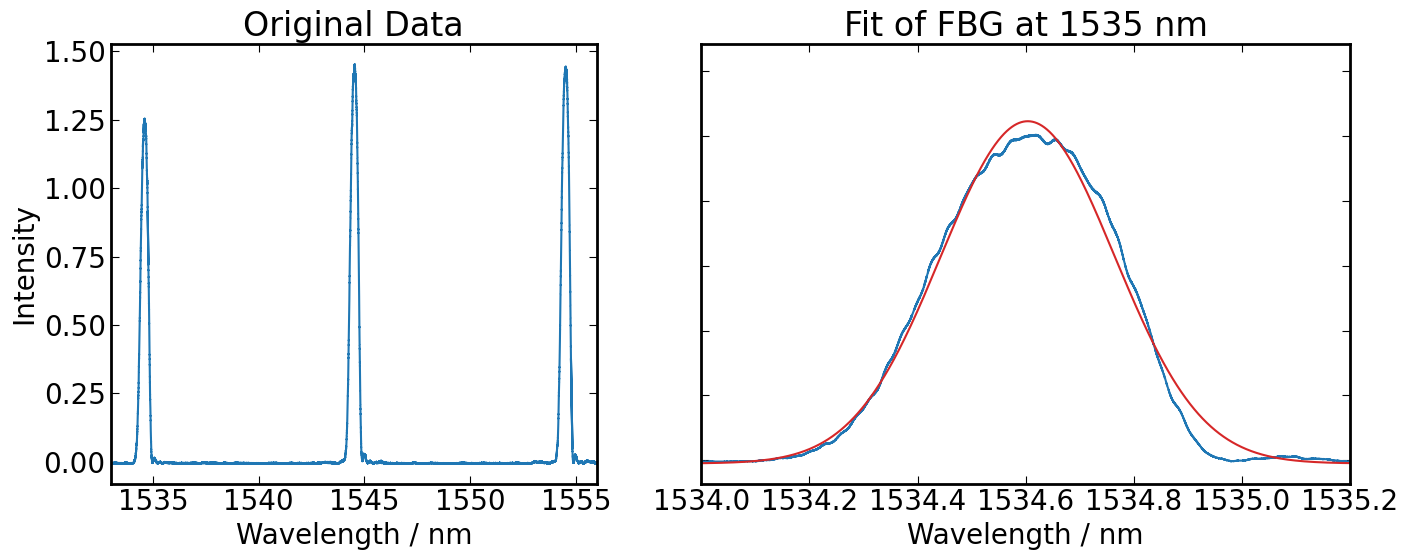

(1554.507844, 1544.524374, 1534.60388)

In [ ]:
plt.figure(figsize=(10,7))
calc_peaks(dfs_fiber[1][0], plot = True)
# plt.figure(figsize=(10,7))
# calc_peaks(dfs_fiber[1][1], plot = True) 

In [ ]:
peaks0 = []
peaks1 = []
peaks2 = []
for dfs in dfs_fiber:
    mean_peaks0 = []
    mean_peaks1 = []
    mean_peaks2 = []
    for df in dfs:
        p0, p1, p2 = calculate_peaks(np.asarray(df.loc[:, "Wavelength (nm)"]), np.asarray(df.loc[:, "Detector 1"]), expected_peaks = 3, fit_type = voigtlin_same_cen_const, plot = False)
        mean_peaks0.append(p0)
        mean_peaks1.append(p1)
        mean_peaks2.append(p2)
    peaks0.append(np.mean(mean_peaks0))
    peaks1.append(np.mean(mean_peaks1))
    peaks2.append(np.mean(mean_peaks2))
        

In [ ]:
ref_temperature = []
for df in dfs_elect:
    ref_temperature.append(np.mean(df))
ref_temperature.append(700.0)


In [ ]:
# ref_temperature.append(800.0)
# print(peaks2)
# peaks1.append(1554.6050203108377)
# print(peaks1)
# peaks0.append(1544.6199199602122)
# print(peaks0)



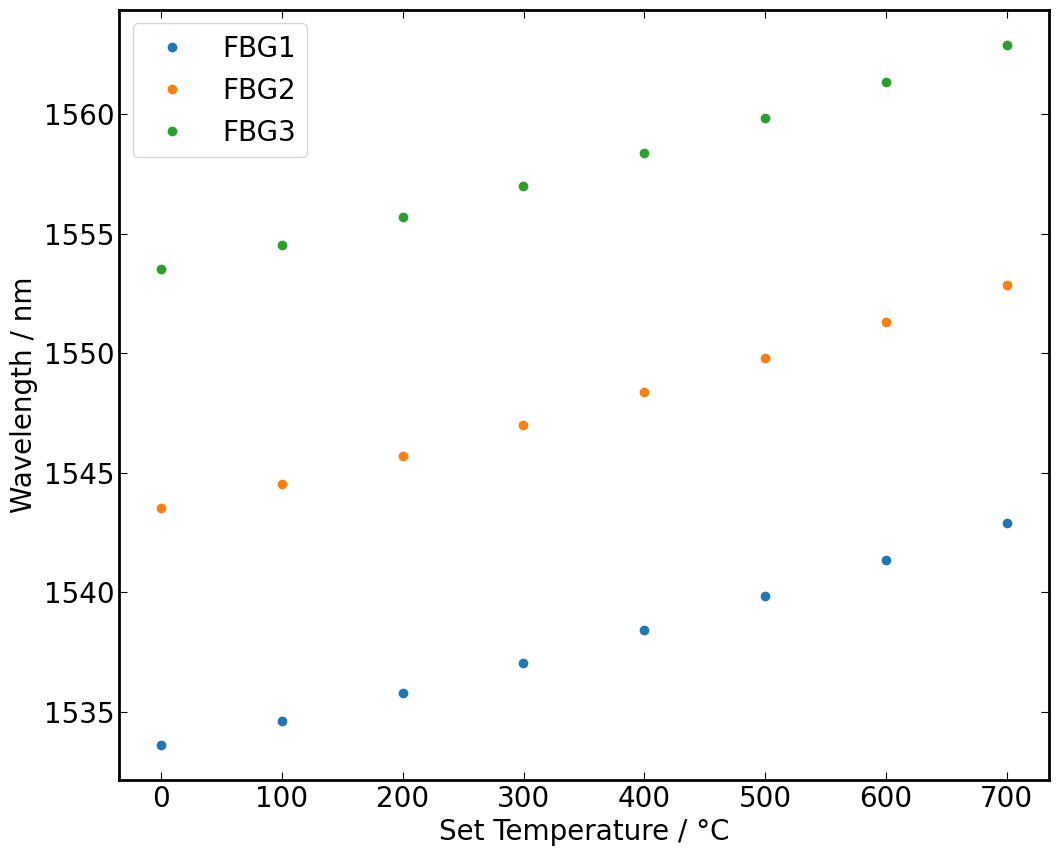

In [ ]:
plt.figure(figsize=(12,10))
# plt.plot(set_temperature, peaks0, 'o', label = 'FBG1')
plt.plot(ref_temperature, peaks0, 'o', label = 'FBG1')
# plt.plot(set_temperature, peaks1, 'o', label = 'FBG2')
plt.plot(ref_temperature, peaks1, 'o', label = 'FBG2')
# plt.plot(set_temperature, peaks2, 'o', label = 'FBG3')
plt.plot(ref_temperature, peaks2, 'o', label = 'FBG3')
plt.ylabel('Wavelength / nm')
plt.xlabel('Set Temperature / °C')
plt.legend(loc='best')
plt.show()

In [ ]:
def w_to_t(peaks, t, FBG, plot = False, legend = True):
    def poly_fit(x, a, b, c):
        return a + b*x + c*x**2 #+ d*x**3 #+ e*x**4
    popt, pcov = curve_fit(poly_fit, peaks, t)  
    if plot == True:
        marker = plt.plot(peaks, t, 'o', label = f'Measured values for FBG {FBG}')
        color = marker[0].get_color()
        plt.plot(peaks, poly_fit(peaks, *popt), ':', label = f'Fit function for FBG {FBG}', color=color)
        if legend == True:
            plt.title('Fitting function for temperature calculation')
            plt.xlabel('Wavelength difference / nm')
            plt.ylabel('Temperature / °C')
            plt.legend(loc='lower right')
    return popt, poly_fit(peaks, *popt)


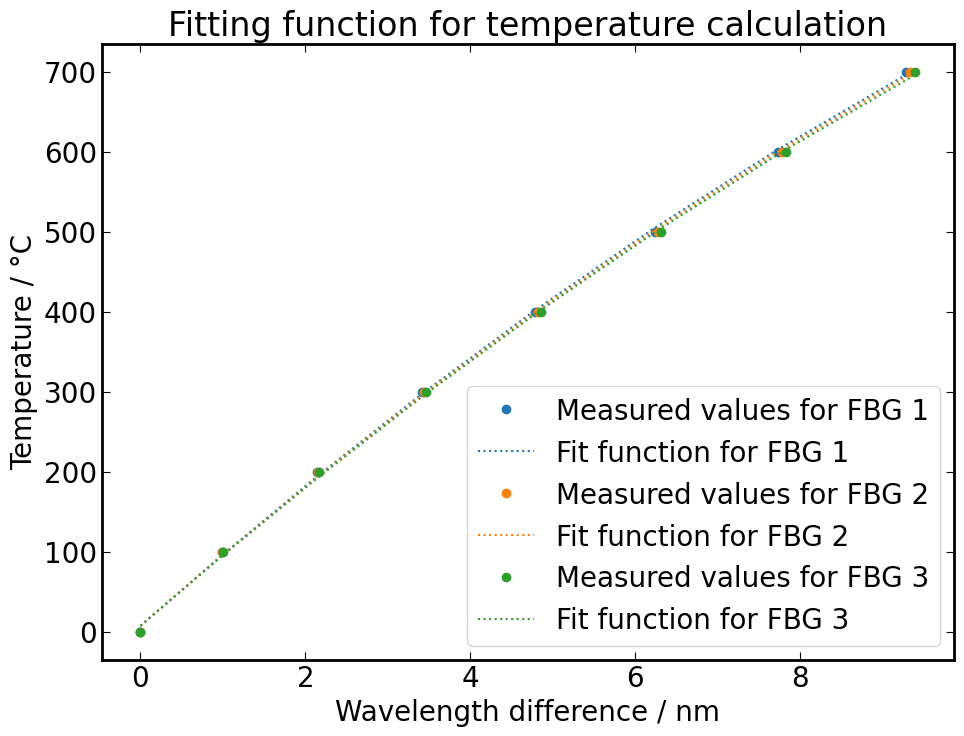

In [ ]:
# %matplotlib ipympl
load_default_plot_font(fontsize = 20)
plt.figure(figsize=(11,8))
popt0, t0 = w_to_t(np.array(peaks0-peaks0[0]), ref_temperature, 1, plot=True)
popt1, t1 = w_to_t(np.array(peaks1-peaks1[0]), ref_temperature, 2, plot=True)
popt2, t2 = w_to_t(np.array(peaks2-peaks2[0]), ref_temperature, 3, plot=True)
plt.show()

In [ ]:
diff0 = peaks0[-1]-peaks0[0]
diff1 = peaks1[-1]-peaks1[0]
diff2 = peaks2[-1]-peaks2[0]
print(diff0)
print(diff1)
print(diff2)

print(abs(diff0-diff2))


9.277182833333427
9.327050166666595
9.394188333333204
0.11700549999977738


(595.0, 705.0)

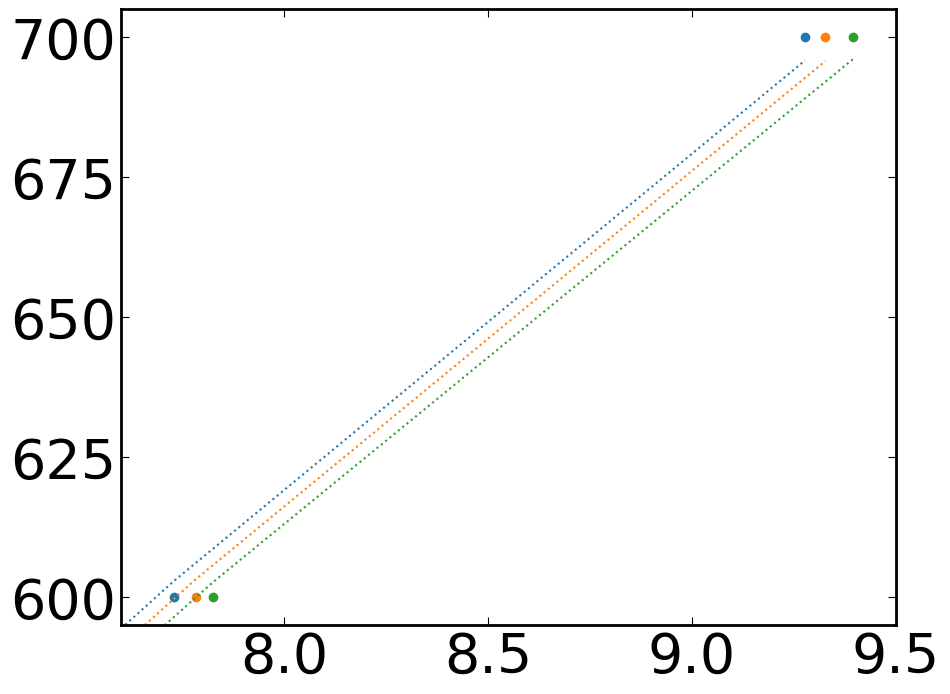

In [ ]:
# %matplotlib ipympl
load_default_plot_font(fontsize = 40)
plt.figure(figsize=(10,8))
w_to_t(np.array(peaks0-peaks0[0]), ref_temperature, 1, plot=True, legend=False)
w_to_t(np.array(peaks1-peaks1[0]), ref_temperature, 2, plot=True, legend=False)
w_to_t(np.array(peaks2-peaks2[0]), ref_temperature, 3, plot=True, legend=False)
plt.xlim(7.6,9.5)
plt.ylim(595.0,705.0)


In [ ]:
print(popt0, peaks0[0])
print(popt1, peaks1[0])
print(popt2, peaks2[0])


[ 7.16257355 91.22856307 -1.83185557] 1533.6190611666668
[ 7.29485246 90.4193956  -1.78066693] 1543.5360768333333
[ 7.26378985 89.88553396 -1.76343146] 1553.5102583333335


In [ ]:
def residuals(peaks, t, FBG, ref, ref_temperature):
    plt.plot([peaks[0], peaks[-1]], [0,0], color='black')
    plt.plot(peaks, t-ref_temperature, 'o', label = f'Measured values for FBG {FBG}')
    plt.title('Residuals')
    plt.xlabel('Wavelength difference / nm')
    plt.ylabel('Temperature difference / K')
    plt.legend(loc='best')




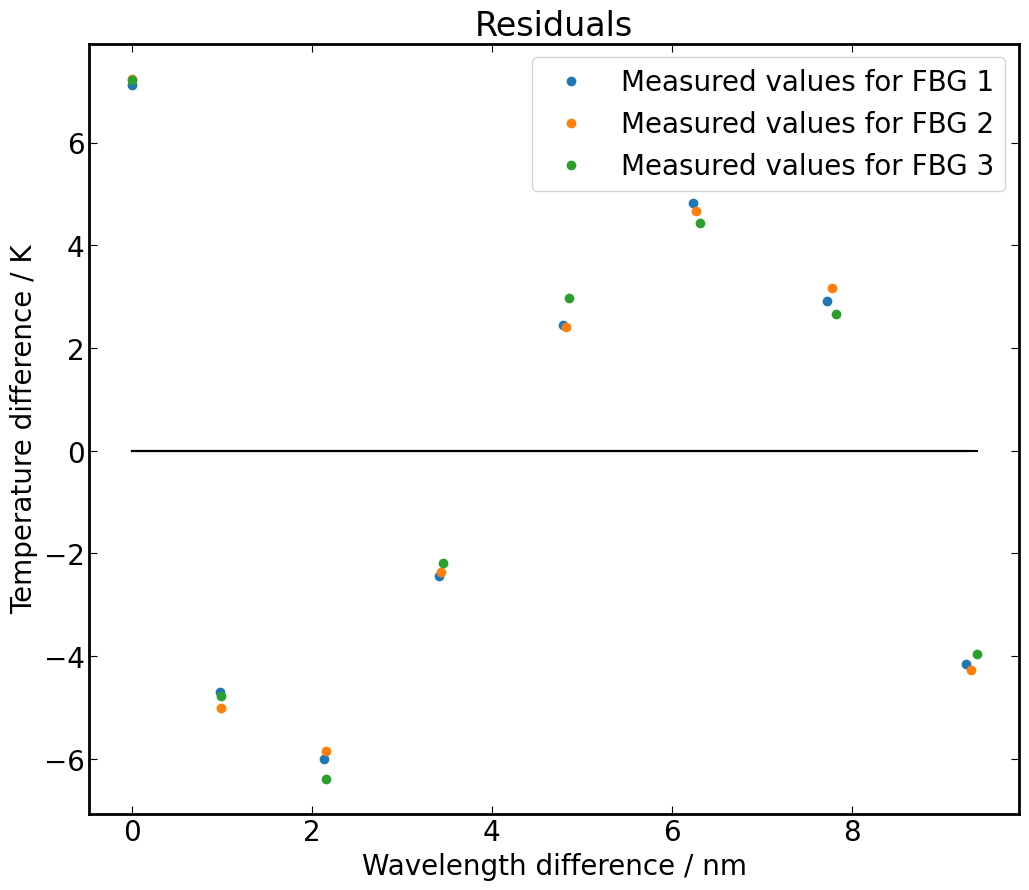

In [ ]:
load_default_plot_font(fontsize = 20)
plt.figure(figsize=(12,10))
residuals(np.array(peaks0-peaks0[0]), t0, 1, t1, ref_temperature)
residuals(np.array(peaks1-peaks1[0]), t1, 2, t1, ref_temperature)
residuals(np.array(peaks2-peaks2[0]), t2, 3, t1, ref_temperature)
